In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import re

import geopandas as gpd
import requests,json


from shapely import geos
from shapely.geometry import Point
import fiona
from fiona.crs import from_epsg,from_string

from geopandas import GeoDataFrame
from shapely.geometry import Polygon
from geopandas import GeoSeries


from shapely import geometry
from shapely.geometry import shape,LineString,Point,Polygon

import osmnx as ox
import networkx as nx

import folium

from folium import IFrame

import seaborn as sns
import branca

In [3]:
def rest(address):
    try:
        url = 'https://api.tomtom.com/search/2/geocode/{}.json?&key=h2n93GznJsnsDHtv2vPpdT9GmJijp9o9&countrySet=TWN&language=zh-TW&limit=1'.format(address)
        response = requests.get(url)
        data = response.text
        js = json.loads(str(data))
        return js['results'][0]['position']
    except Exception as e:
        print(f'An Error occurred: {e}')
        return {'lat':0,'lon':0}
    
def trans(gdf):
    gdf.crs = {'init' :'epsg:3824'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs({'init' :'epsg:4326'})
    return gdf

def utf2asc(s):
    return str(str(s).encode('ascii', 'xmlcharrefreplace'))[2:-1]

heading3 = """<h3>{}</h3>""".format

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os
os.chdir(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data')

# 村里邊界資料整理

In [6]:
gdf=gpd.read_file(r'C:/Users/RT009223/GIS/村里/VILLAGE_MOI_1090423.shp',encoding='utf-8')
gdf=gdf.loc[:,['COUNTYNAME','TOWNNAME','VILLNAME','geometry']]
gdf=trans(gdf)
print(gdf.shape)

(7965, 4)


In [7]:
gdf[gdf['VILLNAME'].isna()]

,COUNTYNAME,TOWNNAME,VILLNAME,geometry
0,屏東縣,東港鎮,None,"POLYGON ((120.48059 22.42686, 120.47641 22.428..."
214,連江縣,莒光鄉,None,"POLYGON ((119.96615 25.97504, 119.96612 25.975..."
215,連江縣,莒光鄉,None,"POLYGON ((119.96638 25.97522, 119.96636 25.975..."
216,連江縣,莒光鄉,None,"POLYGON ((119.96641 25.97532, 119.96641 25.975..."
217,連江縣,莒光鄉,None,"POLYGON ((119.96627 25.97487, 119.96626 25.974..."
...,...,...,...,...
7346,新北市,萬里區,None,"POLYGON ((121.69211 25.20408, 121.69217 25.203..."
7347,新北市,萬里區,None,"POLYGON ((121.68692 25.20635, 121.68702 25.204..."
7366,新北市,金山區,None,"POLYGON ((121.65137 25.22593, 121.65152 25.225..."
7392,新北市,石門區,None,"POLYGON ((121.50943 25.28444, 121.50950 25.284..."


In [8]:
gdf=gdf.dropna().reset_index(drop=True)

In [9]:
gdf.COUNTYNAME=list(gdf.COUNTYNAME.apply(lambda x:x.replace('臺','台')))

In [10]:
print(gdf.shape)
gdf.columns=['縣市','行政區','村里','geometry']
gdf.head()


(7760, 4)


,縣市,行政區,村里,geometry
0,高雄市,林園區,中門里,"POLYGON ((120.36772 22.49564, 120.36427 22.498..."
1,高雄市,林園區,港埔里,"POLYGON ((120.37325 22.49123, 120.37147 22.492..."
2,高雄市,旗津區,上竹里,"POLYGON ((120.28976 22.57317, 120.28577 22.577..."
3,高雄市,旗津區,中興里,"POLYGON ((120.30320 22.55568, 120.30284 22.557..."
4,連江縣,南竿鄉,津沙村,"POLYGON ((119.91684 26.14109, 119.91683 26.141..."


# 會員資料整理

In [11]:
df_get_back=pd.read_table(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\TLW會員位置(無正確地址的資料)_一般卡_2019.txt',sep=',')
print(df_get_back.shape)
df_get_back2=pd.read_table(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\1G會員位置(無正確地址的資料)_一般卡_2019.txt',sep=',')
print(df_get_back2.shape)

(212013, 4)
(5029, 4)


In [12]:
df_get_back=pd.concat([df_get_back,df_get_back2]).reset_index(drop=True)
print(df_get_back.shape)
df_get_back=df_get_back.drop_duplicates(subset=['id']).reset_index(drop=True)
print(df_get_back.shape)

(217042, 4)
(215670, 4)


In [13]:
df_get_back=df_get_back[-df_get_back['村里'].isna()].reset_index(drop=True)

In [14]:
df_get_back.head()

,id,縣市,行政區,村里
0,20030517002840,新北市,樹林區,樹興里
1,20050506000409,新北市,泰山區,楓樹里
2,19980313001203,新北市,泰山區,楓樹里
3,20140713000144,新北市,板橋區,振興里
4,20040306000222,高雄市,三民區,本館里


# Mapping資料

In [15]:
#geom=[Point(data.lon,data.lat) for idx, data in df_get_back.iterrows()]

In [16]:
#crs = {'init': 'epsg:4326'}
#df_get_back = gpd.GeoDataFrame(df_get_back, crs=crs, geometry=geom)

In [17]:
#df_get_back.shape

In [17]:
#df_get_back = gpd.tools.sjoin(df_get_back,gdf, how="inner", op='intersects')
#df_get_back.head()

In [18]:
#df_get_back.columns=['id','addr','zone','lon','lat','geometry','index_right','縣市','行政區','村里']
#df_get_back=df_get_back.loc[:,['id','addr','lon','lat','縣市','行政區','村里']]
#df_get_back.head()

In [19]:
#result.columns=['id','addr','lon','lat','geometry','index_right','縣市','行政區','村里']
#result=result.copy().reset_index(drop=True)

In [20]:
#result2=result.copy()

In [21]:
#result=result.iloc[:,1:]
#result.head()

In [22]:
#result.to_csv('TLW會員位置(經整理_配對村里)_一般卡.txt',index=0)

In [18]:
result=pd.read_table(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\TLW會員位置(經整理_配對村里)_一般卡_2019.txt',sep=',')
print(result.shape)
result2=pd.read_table(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\1G會員位置(經整理_配對村里)_一般卡_2019.txt',sep=',')
print(result2.shape)

(1618625, 7)
(20595, 7)


In [19]:
result=pd.concat([result,result2]).reset_index(drop=True)
print(result.shape)
result=result.drop_duplicates(subset=['id']).reset_index(drop=True)
print(result.shape)

(1639220, 7)
(1627776, 7)


In [20]:
result.head()

,id,addr,lon,lat,縣市,行政區,村里
0,20000408000030,新北市中和區秀景里11鄰秀朗路三段175巷2號 ...,121.524606,24.991220,新北市,中和區,秀景里
1,20000516007486,新北市永和區河堤里8鄰永和路二段425巷57弄1號 ...,121.513703,25.017218,新北市,永和區,河堤里
2,20000516009165,臺北市文山區興旺里17鄰福興路78巷20弄55號 ...,121.551579,25.005164,台北市,文山區,興旺里
3,20000516020881,新北市新店區大豐里7鄰建國路164之1號 ...,121.538830,24.979579,新北市,新店區,大豐里
4,20020215000832,臺北市中山區力行里1鄰長安東路二段173號 ...,121.542232,25.048415,台北市,中山區,力行里


In [21]:
df_get_back=df_get_back[-df_get_back.id.isin(result.id)]
print(df_get_back.shape)

(40026, 4)


In [22]:
result=pd.concat([result,df_get_back]).reset_index(drop=True)

In [23]:
result.shape

(1667802, 7)

# 會員消費額

In [24]:
#sales=pd.read_csv(r'C:\Users\RT009223\TestriteGroup\滲透率專案\01_raw data\TLW2020H1一般卡會員消費金額.csv',error_bad_lines=False,header=None)
#sales.columns=['id','sale']
#sales.shape

In [26]:
sales=pd.read_csv(r'C:\Users\RT009223\TestriteGroup\滲透率專案\01_raw data\TLW2019一般卡會員消費金額.csv',error_bad_lines=False,header=None)
sales.columns=['id','sale']
print(sales.shape)
sales2=pd.read_csv(r'C:\Users\RT009223\TestriteGroup\滲透率專案\01_raw data\1G2019一般卡會員消費金額.csv',error_bad_lines=False,header=None)
sales2.columns=['id','sale']
print(sales2.shape)

(1830640, 2)
(25624, 2)


In [27]:
sales=pd.concat([sales,sales2]).reset_index(drop=True)
print(sales.shape)

(1856264, 2)


In [28]:
sales=sales.groupby(['id'])['sale'].sum().reset_index()

In [29]:
sales.head()

,id,sale
0,18991230000017,9268.0
1,18991230000028,332.0
2,18991230000033,1863.0
3,18991230000060,3733.0
4,18991230000062,2816.0


In [30]:
sales.sale.sum()

8099317316.329998

In [31]:
sales.id.isin(result.id).sum()

1667791

In [32]:
result=pd.merge(result,sales).reset_index(drop=True)

In [33]:
result.shape

(1667791, 8)

# 人口資料整理

In [34]:
pop=pd.read_excel(r'台灣2019年村里人口.xlsx')

In [35]:
pop['縣市']=pop['縣市'].str.replace('\xa0','')
pop['行政區']=pop['行政區'].str.replace('\xa0','')
pop['村里']=pop['村里'].str.replace('\xa0','')

In [36]:

#公舘里~公館里
#上舘里~上館里
#石[曹]里~石𥕢里
#鷄林里~雞林里
#水磜村~水祭村
#珊湖里~珊瑚里

In [37]:
gdf.columns=['縣市','行政區','村里','geometry']

In [38]:
gdf['縣市']=list(gdf['縣市'].apply(lambda x:x.replace('臺','台')))
gdf['行政區']=list(gdf['行政區'].apply(lambda x:x.replace('臺','台')))
gdf['村里']=list(gdf['村里'].apply(lambda x:x.replace('臺','台')))
pop['縣市']=list(pop['縣市'].apply(lambda x:x.replace('臺','台')))
pop['行政區']=list(pop['行政區'].apply(lambda x:x.replace('臺','台')))
pop['村里']=list(pop['村里'].apply(lambda x:x.replace('臺','台')))

gdf['村里']=gdf['村里'].apply(lambda x:x.replace('舘','館'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('舘','館'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('双','雙'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('双','雙'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))

gdf['村里']=gdf['村里'].apply(lambda x:x.replace('欍','瓊'))

pop['村里']=pop['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))

pop['村里']=pop['村里'].apply(lambda x:x.replace('欍','瓊'))


pop['村里']=pop['村里'].apply(lambda x:x.replace('溝垻里','溝埧里'))
pop['村里']=pop['村里'].apply(lambda x:x.replace('崙峰里','崙峯里'))

In [39]:
result['村里']=result['村里'].apply(lambda x:x.replace('舘','館'))
result['村里']=result['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
result['村里']=result['村里'].apply(lambda x:x.replace('双','雙'))
result['村里']=result['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
result['村里']=result['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
result['村里']=result['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))
result['村里']=result['村里'].apply(lambda x:x.replace('欍','瓊'))

In [40]:
#result2=result.groupby(['縣市','行政區','村里'])['id'].count().reset_index()
result2=result.groupby(['縣市','行政區','村里']).agg({'id':'count', 'sale': 'sum'}).reset_index()
result2.columns=['縣市','行政區','村里','會員數','消費額']
result2.shape

(7681, 5)

In [41]:
result2['平均消費額']=round(result2['消費額']/result2['會員數'])

In [42]:
result2=pd.merge(pop,result2,how='left')
result2.shape

(7605, 8)

In [43]:
result2[-(result2['縣市']+result2['行政區']+result2['村里']).isin(pop['縣市']+pop['行政區']+pop['村里'])]['縣市'].unique()

array([], dtype=object)

In [44]:
pop[-(pop['行政區']+pop['村里']).isin(gdf['行政區']+gdf['村里'])]

,縣市,行政區,村里,戶口,人口


In [45]:
#gdf[gdf['村里']=='好茶村']

In [46]:
result2['會員數'].sum()

1666905.0

In [47]:
gdf_final=pd.merge(gdf,result2,how='right')

In [48]:
gdf_final['會員數'][gdf_final['會員數'].isna()]=0

In [49]:
gdf_final['site']=gdf_final['縣市']+gdf_final['行政區']+gdf_final['村里']
gdf_final

,縣市,行政區,村里,geometry,戶口,人口,會員數,消費額,平均消費額,site
0,高雄市,林園區,中門里,"POLYGON ((120.36772 22.49564, 120.36427 22.498...",1120,2894,94.0,373053.92,3969.0,高雄市林園區中門里
1,高雄市,林園區,港埔里,"POLYGON ((120.37325 22.49123, 120.37147 22.492...",819,2060,56.0,257735.73,4602.0,高雄市林園區港埔里
2,高雄市,旗津區,上竹里,"POLYGON ((120.28976 22.57317, 120.28577 22.577...",1391,3254,121.0,447723.14,3700.0,高雄市旗津區上竹里
3,高雄市,旗津區,中興里,"POLYGON ((120.30320 22.55568, 120.30284 22.557...",1064,2877,143.0,437826.18,3062.0,高雄市旗津區中興里
4,屏東縣,潮州鎮,新榮里,"POLYGON ((120.54005 22.54951, 120.54019 22.549...",594,1394,62.0,269813.81,4352.0,屏東縣潮州鎮新榮里
...,...,...,...,...,...,...,...,...,...,...
7600,基隆市,七堵區,實踐里,"POLYGON ((121.70123 25.08284, 121.70167 25.081...",1691,4446,214.0,1069773.15,4999.0,基隆市七堵區實踐里
7601,基隆市,七堵區,堵北里,"MULTIPOLYGON (((121.69626 25.08189, 121.69423 ...",1604,4252,230.0,1179173.73,5127.0,基隆市七堵區堵北里
7602,基隆市,七堵區,堵南里,"POLYGON ((121.69469 25.08739, 121.69373 25.086...",936,2359,132.0,1173509.30,8890.0,基隆市七堵區堵南里
7603,基隆市,暖暖區,暖東里,"POLYGON ((121.74707 25.09037, 121.74748 25.090...",188,464,17.0,57788.00,3399.0,基隆市暖暖區暖東里


In [50]:
gdf_final['ratio']=gdf_final['會員數']/gdf_final['戶口']
gdf_final['ratio2']=gdf_final['ratio']
gdf_final.loc[gdf_final['ratio2']>0.6,'ratio2']=0.6
gdf_final['percent']=gdf_final['ratio'].map(lambda x:str(round(x*100,1))+'%')
#gdf_final=gdf_final.set_index(gdf_final.site)
gdf_final['MarketPotential']=(gdf_final['戶口']-gdf_final['會員數']).astype('int')

In [51]:
gdf_final['平均消費額2']=gdf_final['平均消費額']
gdf_final['平均消費額2'][gdf_final['平均消費額']>10000]=10000

{'whiskers': [<matplotlib.lines.Line2D at 0x2a00ceace08>,
 'caps': [<matplotlib.lines.Line2D at 0x2a00ce99d48>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a00cea5bc8>],
 'medians': [<matplotlib.lines.Line2D at 0x2a00ce99fc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a00ce93e08>],
 'means': []}

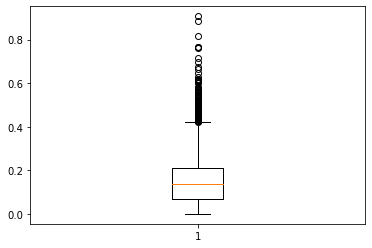

In [52]:
plt.boxplot(gdf_final['ratio'])

In [53]:
#gdf_final.sort_values(by='ratio',ascending=False).head(10)

In [54]:
#(result.addr.str.contains('營盤里')&result.addr.str.contains('新莊區')).sum()

In [55]:
#gdf_final.sort_values(by=['ratio','戶口'],ascending=[True,False]).head(10)

In [56]:
gdf_final['MarketPotential_normalization']=(gdf_final['MarketPotential']-gdf_final['MarketPotential'].min())/(gdf_final['MarketPotential'].max()-gdf_final['MarketPotential'].min())
gdf_final['MarketPotential_density']=(gdf_final['MarketPotential'])/(gdf_final.to_crs({'init': 'epsg:3395'}).area/ 10**6)
gdf_final['MarketPotential_density_normalization']=(gdf_final['MarketPotential_density']-gdf_final['MarketPotential_density'].min())/(gdf_final['MarketPotential_density'].max()-gdf_final['MarketPotential_density'].min())
gdf_final['percent']=gdf_final['ratio'].map(lambda x:str(round(x*100,1))+'%')

In [57]:
gdf_final['平均消費額_normalization']=(gdf_final['平均消費額2']-gdf_final['平均消費額2'].min())/(gdf_final['平均消費額2'].max()-gdf_final['平均消費額2'].min())

In [58]:
gdf_final.loc[gdf_final['平均消費額_normalization'].isna(),['平均消費額_normalization']]=0

In [59]:
gdf_final.head()

,縣市,行政區,村里,geometry,戶口,人口,會員數,消費額,平均消費額,site,ratio,ratio2,percent,MarketPotential,平均消費額2,MarketPotential_normalization,MarketPotential_density,MarketPotential_density_normalization,平均消費額_normalization
0,高雄市,林園區,中門里,"POLYGON ((120.36772 22.49564, 120.36427 22.498...",1120,2894,94.0,373053.92,3969.0,高雄市林園區中門里,0.083929,0.083929,8.4%,1026,3969.0,0.093508,417.143921,0.010994,0.394052
1,高雄市,林園區,港埔里,"POLYGON ((120.37325 22.49123, 120.37147 22.492...",819,2060,56.0,257735.73,4602.0,高雄市林園區港埔里,0.068376,0.068376,6.8%,763,4602.0,0.068940,499.051963,0.013154,0.457651
2,高雄市,旗津區,上竹里,"POLYGON ((120.28976 22.57317, 120.28577 22.577...",1391,3254,121.0,447723.14,3700.0,高雄市旗津區上竹里,0.086988,0.086988,8.7%,1270,3700.0,0.116301,958.304679,0.025261,0.367025
3,高雄市,旗津區,中興里,"POLYGON ((120.30320 22.55568, 120.30284 22.557...",1064,2877,143.0,437826.18,3062.0,高雄市旗津區中興里,0.134398,0.134398,13.4%,921,3062.0,0.083699,296.278724,0.007808,0.302924
4,屏東縣,潮州鎮,新榮里,"POLYGON ((120.54005 22.54951, 120.54019 22.549...",594,1394,62.0,269813.81,4352.0,屏東縣潮州鎮新榮里,0.104377,0.104377,10.4%,532,4352.0,0.047361,3048.389573,0.080364,0.432533


In [60]:
gdf_final.to_excel(r'C:\Users\RT009223\TestriteGroup\滲透率專案\04_TLW\result\TLW_1G_2019台灣.xlsx',index=0)

# 特力屋店點(部分) 

In [61]:
TLW=pd.read_excel('特力屋店點.xlsx')
TLW

,name,addr,type,lat,lon
0,士林店,台北市士林區基河路258號,0,25.092606,121.520207
1,內湖店,台北市內湖區新湖三路23號,0,25.062030,121.574170
2,大安安和店(社區店),台北市大安區安和路二段74巷3號,2,25.030080,121.551591
3,板橋新埔店(社區店),新北市板橋區文化路一段360號,2,25.023634,121.468810
4,新莊店,新北市新莊區中正路620號,0,25.029195,121.422794
5,中和店,新北市中和區中山路二段291號,0,25.002220,121.496140
6,新店店,新北市新店區中興路三段1號4F,0,24.976798,121.546088
7,土城店,新北市土城區青雲路152號2樓,0,24.983344,121.458963
8,三峽店,新北市樹林區大成路85號,0,24.948291,121.381575
9,蘆洲集賢店(社區店),新北市蘆洲區集賢路401號,2,25.081730,121.480254


# 畫圖

In [62]:
# 各車站定位
台北車站=[25.047741, 121.517384]
中壢車站=[24.953737, 121.225607]
台中車站=[24.137264, 120.686669]
嘉義車站=[23.479119, 120.441138]

#各縣市邊框顏色, '澎湖縣','金門縣','連江縣' '澎湖縣':'#00896C','金門縣':'#00896C','連江縣':'#00896C',
print(gdf_final['縣市'].unique())
site=['基隆市','新北市', '台北市','桃園市','新竹縣','新竹市','苗栗縣','台中市','彰化縣','南投縣',
      '雲林縣','嘉義縣','嘉義市','台南市',
      '高雄市','屏東縣','宜蘭縣','花蓮縣','台東縣']

site_colors={'基隆市':'#F17C67','新北市':'#F17C67', '台北市':'#F17C67',
            '桃園市':'#33A6B8','新竹縣':'#33A6B8','新竹市':'#33A6B8','苗栗縣':'#33A6B8',
            '台中市':'#00896C','彰化縣':'#00896C','南投縣':'#00896C',
            '雲林縣':'#465D4C','嘉義縣':'#465D4C','嘉義市':'#465D4C','台南市':'#465D4C',
            '高雄市':'#6F3381','屏東縣':'#6F3381',
            '宜蘭縣':'#F7D94C','花蓮縣':'#F7D94C','台東縣':'#F7D94C'}

#想畫顏色的變數
variable='ratio2'

#設定色階
gdf_final['id']=gdf_final.index
color=gdf_final.set_index('id')[variable]

high=color.max()
low=color.min()
p=high/8
print(p)

colorscale = branca.colormap.linear.YlOrRd_09.scale(low, high)
colorscale




['高雄市' '屏東縣' '花蓮縣' '新竹市' '台東縣' '台中市' '嘉義縣' '桃園市' '南投縣' '雲林縣' '新竹縣' '嘉義市'
 '台南市' '基隆市' '苗栗縣' '宜蘭縣' '彰化縣' '新北市' '台北市']
0.075


In [63]:
color.isna().sum()

0

In [64]:
colorscale

In [65]:
# 顏色 style
def style_function(feature):
    colors = color.get(int(feature['id']), None)
    site_color=site_colors.get(feature['properties']['縣市'])
    return {
        'fillOpacity': 0.5,
        'weight': 1,
        'color':site_color,
        'fillColor': '#fff' if colors is None else colorscale(colors)
    }

In [66]:
# 設定圖例
colormap=colorscale.to_step(index=[0, p*1, p*2, p*3, p*4,p*5,p*6,p*7,p*8])
colormap.caption ='Member Penetration Rates'
#colormap.caption ='Average Consumption'

In [67]:
mm=folium.Map(location=台北車站,zoom_start=14)
for s in site:
    folium.GeoJson(
        gdf_final[gdf_final['縣市']==s][['geometry','縣市','行政區','村里','戶口','人口','會員數','ratio','percent','MarketPotential','MarketPotential_density','平均消費額','平均消費額_normalization']],
        name=s, 
        style_function=style_function,
        highlight_function=lambda x: {'weight':3, 
                                        'color':site_colors.get(x['properties']['縣市']),
                                        'fillOpacity':0.75},
        smooth_factor=2.0,
        tooltip=folium.features.GeoJsonTooltip(fields=['縣市','行政區','村里','戶口','percent','平均消費額',],
                                                  aliases=['縣市','行政區','村里','戶數','滲透率','平均消費額'], 
                                                  labels=True, 
                                                  sticky=True,
                                                  toLocaleString=True
                                                 )
    ).add_to(mm)

for i in range(TLW.shape[0]):
    if TLW.type[i]==0:
        iframe = IFrame(html=heading3(utf2asc(TLW.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[TLW.lat[i], TLW.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='orange')).add_to(mm)
    elif TLW.type[i]==2:
        iframe = IFrame(html=heading3(utf2asc(TLW.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[TLW.lat[i], TLW.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='pink')).add_to(mm)
    else:  
        iframe = IFrame(html=heading3(utf2asc(TLW.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[TLW.lat[i], TLW.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='gray')).add_to(mm)

colormap.add_to(mm)

folium.LayerControl().add_to(mm)


In [66]:
#mm

In [68]:
mm.save(r'C:\Users\RT009223\TestriteGroup\滲透率專案\04_TLW\result\台灣2019年TLW_1G_滲透率.html')